In [1]:
# This injects fake planets by (and without using PynPoint)
# 1.  Determining a mask over the host star PSF where nonlinearity/saturation may be an issue
# 2.  Fitting a PCA basis to the masked host star PSF (using unsaturated frames as the basis set)
# 3.  Reconstructing the PSF
# 4.  Injecting it with a variety of amplitudes/angles around the host star

# created 2019 Jan. 11 by E.S.

## SECTION TO INITIALIZE

In [24]:
import urllib
import numpy as np
import matplotlib.pyplot as plt
import scipy
from scipy import ndimage
import sklearn
from sklearn.decomposition import PCA
from sklearn.decomposition import RandomizedPCA
import time
from matplotlib.colors import LogNorm

In [2]:
import os
from astropy.io import fits
from astropy.modeling import models, fitting

In [3]:
# stem 

stem_base = ('/home/../../media/unasemaje/Elements/lbti_data_reduction/180507_fizeau_altair/')
stem_retrieve = (stem_base+'05_centered/') # use frames which have already been centered and are well-behaved, for now
stem_place = (stem_base+'testing/')

# READ IN PSF FRAMES TO FORM THE BASIS SET

In [4]:
def make_pca_basis_cube_from_readouts(stem_retrieve,
                                      stem_place,
                                      write_string,
                                      startFrame,
                                      endFrame,
                                      n_PCA):
    '''
    INPUTS
    stem_retrieve: filename stem for retrieving data
    stem_place: stem of path for saving output
    write_string: an extra string to put in filenames
    startFrame: the first frame of the training set
    endFrame: the last frame of the training set
    n_PCA: number of PCA components to generate
    
    OUTPUTS
    (none; FITS files are written out)
    
    N.b. The first version of this function appeared in make_pca_background_basis_cube.ipynb
    '''
    
    # initialize counter
    counter = 0
    
    test_cube = np.nan*np.ones((endFrame-startFrame+1,100,100),dtype = np.int64)
    
    # loop through each training set image and add it to a cube (endFrame is inclusive)
    print('Putting training frames into cube...')
    for framenum in range(startFrame,endFrame+1): #endFrame+1): # 83, 67108
            
        # raw data (except that readout glitch correction has been done)
        filename = 'lm_180507_'+str("{:0>6d}".format(framenum))+'_nPCA164.fits'
        img_string = stem_retrieve + filename
    
        # if FITS file exists in the first place
        if ((np.mod(framenum,1) == 0) & os.path.isfile(img_string)): 
            
            # read in image
            sciImg, header = fits.getdata(img_string,0,header=True)
            
            # check header fields for filters, integration times, phase control
            if (header["LMIR_FW1"]=="94800" and header["LMIR_FW2"]=="ND2.0-T1" 
                and header["LMIRFW25"]=="Lspec2.8-4.0" and header["LMIR_FW3"]=="Open"
                and header["LMIR_FW4"]=="Br-Alpha-On" and header["ACTEXP"]==145976
                and header["PCCLOSED"]==1):
                
                print("Reading in " + filename)
        
                # add to cube
                test_cube[counter,:,:] = sciImg
                
                # advance the counter
                counter += 1
                
                ## ## TESTING 
                #plt.imshow(sciImg)
                #plt.imshow(test_cube[counter,:,:])
                #plt.show()
                
                ## ## TESTING
                #print(counter)

            else:
                
                print("NOT READING IN " + filename)
                continue # skip and move to next frame
            
        else:
            
            print('Hang on-- frame '+img_string+' not found!')
    
    # remove leftover slices of all nans
    test_cube = test_cube[0:counter,:,:]
    
    # at this point, test_cube holds the frames to be used as a training set
    
    # flatten each individual frame into a 1D array
    print('Flattening the training cube...')
    
    ## ## TESTING
    print(np.shape(test_cube))
    
    test_cube_1_1ds = np.reshape(test_cube,
                                 (np.shape(test_cube)[0],
                                  np.shape(test_cube)[1]*np.shape(test_cube)[2])) 

    ## ## TESTING
    print(np.shape(test_cube_1_1ds))
    print(test_cube_1_1ds[0])
    
    ## carefully remove nans before doing PCA
    
    # indices of finite elements over a single flattened frame
    idx = np.isfinite(test_cube_1_1ds[0,:])
        
    # reconstitute only the finite elements together in another PCA cube of 1D slices
    training_set_1ds_noNaN = np.nan*np.ones((len(test_cube_1_1ds[:,0]),np.sum(idx))) # initialize array with slices the length of number of finite elements
    for t in range(0,len(test_cube_1_1ds[:,0])): # for each PCA component, populate the arrays without nans with the finite elements
        training_set_1ds_noNaN[t,:] = test_cube_1_1ds[t,idx]
    
    # do PCA on the flattened `cube' with no NaNs
    print('Doing PCA...')
    #pca = PCA(n_components=n_PCA, svd_solver='randomized') # initialize object
    pca = RandomizedPCA(n_PCA) # for Python 2.7 
    
    ## ## TESTING
    print(np.shape(training_set_1ds_noNaN))
    #for i in range(0,len(training_set_1ds_noNaN)):
    #    print(training_set_1ds_noNaN[i,0:4])
    
    test_pca = pca.fit(training_set_1ds_noNaN) # calculate PCA basis set
    del training_set_1ds_noNaN # clear memory
    
    # reinsert the NaN values into each 1D slice of the PCA basis set
    print('Putting PCA components into cube...')
    pca_comp_cube = np.nan*np.ones((n_PCA,
                                    np.shape(test_cube)[1],
                                    np.shape(test_cube)[2]), 
                                   dtype = np.float32) # initialize a cube of 2D slices
    for slicenum in range(0,n_PCA): # for each PCA component, populate the arrays without nans with the finite elements
        pca_masked_1dslice_noNaN = np.nan*np.ones((len(test_cube_1_1ds[0,:]))) # initialize a new 1d frame long enough to contain all pixels
        pca_masked_1dslice_noNaN[idx] = pca.components_[slicenum] # put the finite elements into the right positions
        pca_comp_cube[slicenum,:,:] = np.reshape(pca_masked_1dslice_noNaN,
                                                 (np.shape(test_cube)[1],
                                                  np.shape(test_cube)[2])).astype(np.float32)
        

    # save input cube FYI
    print('Saving input cube...')
    hdu = fits.PrimaryHDU(test_cube.astype(np.float32))
    del test_cube # clear memory
    hdul = fits.HDUList([hdu])
    write_name = stem_place + 'pca_input_reference_cube.fits'
    hdul.writeto(write_name, overwrite=True)
        
    # save PCA vector cube
    print('Saving PCA cube...')
    t = time.time()
    hdu = fits.PrimaryHDU(pca_comp_cube.astype(np.float32))
    del pca_comp_cube # clear memory
    hdul = fits.HDUList([hdu])
    write_name = stem_place + write_string + '.fits'
    hdul.writeto(write_name, overwrite=True)
    
    elapsed = time.time() - t
    print(elapsed)
    print('PCA cube saved as '+write_name)
    print('---')
    

In [5]:
make_pca_basis_cube_from_readouts(stem_retrieve,
                                      stem_place,
                                      write_string = "pca_test",
                                      startFrame = 7120,
                                      endFrame = 7925,
                                      n_PCA = 100)

Putting training frames into cube...
NOT READING IN lm_180507_007120_nPCA164.fits
NOT READING IN lm_180507_007121_nPCA164.fits
NOT READING IN lm_180507_007122_nPCA164.fits
Reading in lm_180507_007123_nPCA164.fits
NOT READING IN lm_180507_007124_nPCA164.fits
NOT READING IN lm_180507_007125_nPCA164.fits
NOT READING IN lm_180507_007126_nPCA164.fits
NOT READING IN lm_180507_007127_nPCA164.fits
NOT READING IN lm_180507_007128_nPCA164.fits
NOT READING IN lm_180507_007129_nPCA164.fits
NOT READING IN lm_180507_007130_nPCA164.fits
NOT READING IN lm_180507_007131_nPCA164.fits
NOT READING IN lm_180507_007132_nPCA164.fits
NOT READING IN lm_180507_007133_nPCA164.fits
NOT READING IN lm_180507_007134_nPCA164.fits
NOT READING IN lm_180507_007135_nPCA164.fits
NOT READING IN lm_180507_007136_nPCA164.fits
NOT READING IN lm_180507_007137_nPCA164.fits
NOT READING IN lm_180507_007138_nPCA164.fits
NOT READING IN lm_180507_007139_nPCA164.fits
NOT READING IN lm_180507_007140_nPCA164.fits
NOT READING IN lm_1805

NOT READING IN lm_180507_007350_nPCA164.fits
NOT READING IN lm_180507_007351_nPCA164.fits
NOT READING IN lm_180507_007352_nPCA164.fits
NOT READING IN lm_180507_007353_nPCA164.fits
NOT READING IN lm_180507_007354_nPCA164.fits
NOT READING IN lm_180507_007355_nPCA164.fits
NOT READING IN lm_180507_007356_nPCA164.fits
Reading in lm_180507_007357_nPCA164.fits
Reading in lm_180507_007358_nPCA164.fits
Reading in lm_180507_007359_nPCA164.fits
Reading in lm_180507_007360_nPCA164.fits
Reading in lm_180507_007361_nPCA164.fits
Reading in lm_180507_007362_nPCA164.fits
Reading in lm_180507_007363_nPCA164.fits
Reading in lm_180507_007364_nPCA164.fits
Reading in lm_180507_007365_nPCA164.fits
Reading in lm_180507_007366_nPCA164.fits
Reading in lm_180507_007367_nPCA164.fits
Reading in lm_180507_007368_nPCA164.fits
Reading in lm_180507_007369_nPCA164.fits
Reading in lm_180507_007370_nPCA164.fits
Reading in lm_180507_007371_nPCA164.fits
Reading in lm_180507_007372_nPCA164.fits
Reading in lm_180507_007373_n

Reading in lm_180507_007578_nPCA164.fits
Reading in lm_180507_007579_nPCA164.fits
Reading in lm_180507_007580_nPCA164.fits
Reading in lm_180507_007581_nPCA164.fits
Reading in lm_180507_007582_nPCA164.fits
Reading in lm_180507_007583_nPCA164.fits
Reading in lm_180507_007584_nPCA164.fits
Reading in lm_180507_007585_nPCA164.fits
Reading in lm_180507_007586_nPCA164.fits
Reading in lm_180507_007587_nPCA164.fits
Reading in lm_180507_007588_nPCA164.fits
Reading in lm_180507_007589_nPCA164.fits
Reading in lm_180507_007590_nPCA164.fits
Reading in lm_180507_007591_nPCA164.fits
Reading in lm_180507_007592_nPCA164.fits
Reading in lm_180507_007593_nPCA164.fits
Reading in lm_180507_007594_nPCA164.fits
Reading in lm_180507_007595_nPCA164.fits
Reading in lm_180507_007596_nPCA164.fits
Reading in lm_180507_007597_nPCA164.fits
Reading in lm_180507_007598_nPCA164.fits
Reading in lm_180507_007599_nPCA164.fits
Reading in lm_180507_007600_nPCA164.fits
Reading in lm_180507_007601_nPCA164.fits
Reading in lm_18

NOT READING IN lm_180507_007796_nPCA164.fits
NOT READING IN lm_180507_007797_nPCA164.fits
NOT READING IN lm_180507_007798_nPCA164.fits
NOT READING IN lm_180507_007799_nPCA164.fits
NOT READING IN lm_180507_007800_nPCA164.fits
NOT READING IN lm_180507_007801_nPCA164.fits
NOT READING IN lm_180507_007802_nPCA164.fits
NOT READING IN lm_180507_007803_nPCA164.fits
NOT READING IN lm_180507_007804_nPCA164.fits
NOT READING IN lm_180507_007805_nPCA164.fits
NOT READING IN lm_180507_007806_nPCA164.fits
NOT READING IN lm_180507_007807_nPCA164.fits
NOT READING IN lm_180507_007808_nPCA164.fits
NOT READING IN lm_180507_007809_nPCA164.fits
NOT READING IN lm_180507_007810_nPCA164.fits
NOT READING IN lm_180507_007811_nPCA164.fits
NOT READING IN lm_180507_007812_nPCA164.fits
NOT READING IN lm_180507_007813_nPCA164.fits
NOT READING IN lm_180507_007814_nPCA164.fits
NOT READING IN lm_180507_007815_nPCA164.fits
Reading in lm_180507_007816_nPCA164.fits
Reading in lm_180507_007817_nPCA164.fits
Reading in lm_1805

Reading in lm_180507_007923_nPCA164.fits
Reading in lm_180507_007924_nPCA164.fits
Reading in lm_180507_007925_nPCA164.fits
Flattening the training cube...
(487, 100, 100)
(487, 10000)
[-100.23302971  -23.39024303  -46.08873337 ...    0.            0.
    0.        ]
Doing PCA...
(487, 10000)


/home/unasemaje/anaconda3/envs/py27/lib/python2.7/site-packages/sklearn/utils/deprecation.py:58: DeprecationWarning: Class RandomizedPCA is deprecated; RandomizedPCA was deprecated in 0.18 and will be removed in 0.20. Use PCA(svd_solver='randomized') instead. The new implementation DOES NOT store whiten ``components_``. Apply transform to get them.
  warnings.warn(msg, category=DeprecationWarning)


Putting PCA components into cube...
Saving input cube...
Saving PCA cube...
0.0227289199829
PCA cube saved as /home/../../media/unasemaje/Elements/lbti_data_reduction/180507_fizeau_altair/testing/pca_test.fits
---


# Make PCA reconstruction of host star PSC

In [20]:
def fit_pca_star(pca_cube, sciImg, mask_weird, n_PCA):
    '''
    INPUTS:
    pca_cube: cube of PCA components
    img_string: full path name of the science image
    sciImg: the science image
    n_PCA: number of PCA components
    
    RETURNS:
    pca spectrum: spectrum of PCA vector amplitudes
    reconstructed PSF: host star PSF as reconstructed with N PCA vector components
    '''
    start_time = time.time()

    # apply mask over weird regions to PCA cube
    pca_cube_masked = np.multiply(pca_cube,mask_weird)

    # apply mask over weird detector regions to science image
    sciImg_psf_masked = np.multiply(sciImg,mask_weird)
            
    ## PCA-decompose
        
    # flatten the science array and PCA cube 
    pca_not_masked_1ds = np.reshape(pca_cube,(np.shape(pca_cube)[0],np.shape(pca_cube)[1]*np.shape(pca_cube)[2]))
    sci_masked_1d = np.reshape(sciImg_psf_masked,(np.shape(sciImg_psf_masked)[0]*np.shape(sciImg_psf_masked)[1]))
    pca_masked_1ds = np.reshape(pca_cube_masked,(np.shape(pca_cube_masked)[0],np.shape(pca_cube_masked)[1]*np.shape(pca_cube_masked)[2]))
    
    ## remove nans from the linear algebra
        
    # indices of finite elements over a single flattened frame
    idx = np.logical_and(np.isfinite(pca_masked_1ds[0,:]), np.isfinite(sci_masked_1d)) 
        
    # reconstitute only the finite elements together in another PCA cube and a science image
    pca_masked_1ds_noNaN = np.nan*np.ones((len(pca_masked_1ds[:,0]),np.sum(idx))) # initialize array with slices the length of number of finite elements
    for t in range(0,len(pca_masked_1ds[:,0])): # for each PCA component, populate the arrays without nans with the finite elements
        pca_masked_1ds_noNaN[t,:] = pca_masked_1ds[t,idx]
    sci_masked_1d_noNaN = np.array(1,np.sum(idx)) # science frame
    sci_masked_1d_noNaN = sci_masked_1d[idx] 
        
    # the vector of component amplitudes
    soln_vector = np.linalg.lstsq(pca_masked_1ds_noNaN[0:n_PCA,:].T, sci_masked_1d_noNaN)
        
    # reconstruct the background based on that vector
    # note that the PCA components WITHOUT masking of the PSF location is being
    # used to reconstruct the background
    recon_2d = np.dot(pca_cube[0:n_PCA,:,:].T, soln_vector[0]).T
    
    d = {'pca_vector': soln_vector[0], 'recon_2d': recon_2d}
    
    return d

/home/unasemaje/anaconda3/envs/py27/lib/python2.7/site-packages/ipykernel_launcher.py:41: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.


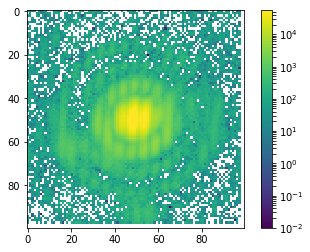

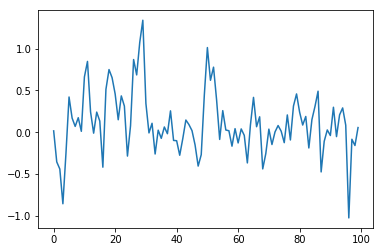

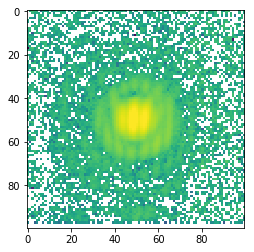

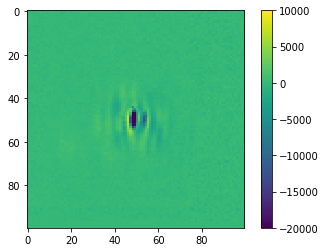

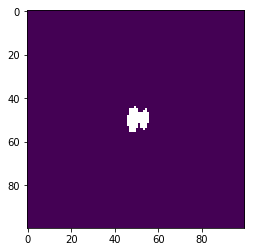

In [33]:
# retrieve the PCA basis
cube_string = stem_place + 'pca_input_reference_cube.fits'
pca_basis_cube, header = fits.getdata(cube_string,0,header=True)

for framenum in range(9000,9001):
    
    # retrieve science image
    sci_filename = stem_retrieve + 'lm_180507_'+str("{:0>6d}".format(framenum))+'_nPCA164.fits'
    sciImg, header = fits.getdata(sci_filename,0,header=True)
    
    # define the mask
    mask_weird = np.ones(np.shape(sciImg))
    mask_weird[sciImg > 35000] = np.nan

    # do the PCA fit
    test = fit_pca_star(pca_basis_cube, sciImg, mask_weird, n_PCA=100)
    
    plt.imshow(sciImg, norm=LogNorm(vmin=0.01, vmax=55000))
    plt.colorbar()
    plt.show()
    
    plt.plot(test['pca_vector'])
    plt.show()
    
    plt.imshow(test['recon_2d'], norm=LogNorm(vmin=0.01, vmax=55000))
    plt.show()
    
    plt.imshow(np.subtract(sciImg,test['recon_2d']), vmin=-20000, vmax=10000)
    plt.colorbar()
    plt.show()
    
    plt.imshow(mask_weird)
    plt.show()


In [16]:
test

{'pca_vector': (array([ 0.01598004, -0.35473801, -0.4400674 , -0.85546665, -0.25155077,
          0.42085258,  0.16887211,  0.06936105,  0.17319991,  0.01067482,
          0.66088421,  0.84613843,  0.24251175, -0.01143263,  0.24040946,
          0.13357626, -0.41823187,  0.51239058,  0.74873316,  0.65217617,
          0.45709403,  0.14891039,  0.43392702,  0.31248439, -0.28533906,
          0.07683086,  0.86870525,  0.68489572,  1.07451507,  1.33849099,
          0.3443277 , -0.0085028 ,  0.10666705, -0.26054876,  0.02407185,
         -0.07329559,  0.06247117, -0.01808806,  0.25516228, -0.09834546,
         -0.10177357, -0.27551706, -0.0761413 ,  0.14562401,  0.09104897,
          0.01844087, -0.15329035, -0.40486366, -0.2686654 ,  0.44140334,
          1.01186442,  0.62063597,  0.77747339,  0.38381337, -0.08633898,
          0.2577735 ,  0.02618768,  0.0174368 , -0.16706325,  0.04244955,
         -0.12840215,  0.0392112 , -0.03790077, -0.36728166,  0.08630738,
          0.41624597,  0

lm_180507_009000_nPCA164.fits


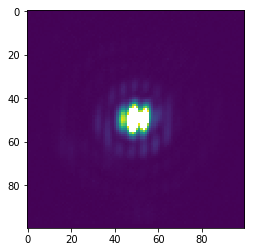

In [9]:
framenum = 9000

#### BELOW FOR FOR LOOP
# fit 2D Gaussian
img_string = 'lm_180507_'+str("{:0>6d}".format(framenum))+'_nPCA164.fits'
    
# if file exists
if os.path.isfile(stem_retrieve+img_string):
        
    # read in image
    sciImg, header = fits.getdata(stem_retrieve+img_string,0,header=True)
        
    print(img_string)
        
    sciImg_masked = np.copy(sciImg)
    mask_threshold = 35000 # pixel counts above this will be masked (refine this later based on linearity data)
    sciImg_masked[sciImg_masked > mask_threshold] = np.nan
        
    #plt.hist(np.ravel(sciImg), bins=1000)
    #plt.xlim([0,5000])
        
    plt.imshow(sciImg_masked)
    plt.show()
    
    # find the PCA spectrum 
    

In [3]:
# Make cookie cut-outs of Fizeau PSFs (note the centering will not be great)
# retrieve from /03_ramp_removed_pca_background_subted/
# deposit in /04_gross_cookie_cutout/

In [ ]:
########################################################################################################################

# Now upsample and center the images again, without using PynPoint (requires Python 3.5 for plots)

In [25]:
#%matplotlib qt

In [4]:
# read in cutout frames

def center_cutouts(framenum):
    '''
    Center PSF cutouts without using PynPoint
    '''

    # fit 2D Gaussian
    img_string = 'lm_180507_'+str("{:0>6d}".format(framenum))+'_nPCA164.fits'
    
    # if file exists
    if os.path.isfile(stem_place+img_string):
        
        # read in image
        sciImg, header = fits.getdata(stem_place+img_string,0,header=True)
        
        # get coordinate grid info
        y, x = np.mgrid[0:np.shape(sciImg)[0],0:np.shape(sciImg)[1]]
        z = np.copy(sciImg)
        
        # make an initial Gaussian guess
        p_init = models.Gaussian2D(amplitude=60000.,
                                   x_mean=50.,
                                   y_mean=50.,
                                   x_stddev=6.,
                                   y_stddev=6.)
        fit_p = fitting.LevMarLSQFitter()

        # fit the data
        p = fit_p(p_init, x, y, z)
        ampl, x_mean, y_mean, x_stdev, y_stdev, theat = p._parameters
        
        # Plot the data with the best-fit model
        '''
        plt.clf()
        plt.figure(figsize=(8, 2.5))
        plt.subplot(1, 3, 1)
        plt.imshow(z, origin='lower', interpolation='nearest', vmin=-10, vmax=60000)
        plt.title("Data")
        plt.subplot(1, 3, 2)
        plt.imshow(p(x, y), origin='lower', interpolation='nearest', vmin=-10, vmax=60000)
        plt.title("Model")
        plt.subplot(1, 3, 3)
        plt.imshow(z - p(x, y), origin='lower', interpolation='nearest', vmin=-10, vmax=60000)
        plt.title("Residual")
        plt.suptitle("Frame "+str("{:0>6d}".format(framenum)))
        plt.savefig(stem_place_centered+'pngs_fits/png_fit_lm_180507_'+str("{:0>6d}".format(framenum))+'.png',overwrite=True)
        plt.close()
        '''
                
        # center the frame
        # N.b. for a 100x100 image, the physical center is at Python coordinate (49.5,49.5)
        # i.e., in between pixels 49 and 50 in both dimensions (Python convention),
        # or at coordinate (50.5,50.5) in DS9 convention
        sciImg_shifted = scipy.ndimage.interpolation.shift(sciImg, shift = [49.5-y_mean, 49.5-x_mean]) # shift in +y,+x convention
        
        # write a cookie-cut frame back out
        hdu = fits.PrimaryHDU(sciImg_shifted,header=header)
        hdul = fits.HDUList([hdu])
        hdul.writeto(stem_place_centered+'lm_180507_'+str("{:0>6d}".format(framenum))+'_nPCA164.fits', 
                     overwrite=True)
        
        print("Centered frame "+str("{:0>6d}".format(framenum)))